In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla
from scipy.sparse.linalg import inv

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [3]:
def local_operators(parameters):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''

    W = parameters['W']
    Ny = parameters['Ny']
    k = parameters['k']       
    Nx = parameters['W'] + parameters['Ny']+ 1
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []

    for (x,y) in [(x,y) for y in range(Ny-1) for x in range(Nx)]:
        
        row_Tx += [x + Nx*y]
        col_Tx += [((x+1)%Nx) + Nx*y]
        data_Tx += [1]
        
        row_Ty += [x + Nx*y]
        col_Ty += [x + Nx*((y+1)%Ny)]
        data_Ty += [1]
        
    for x in range(Nx):
       
        row_Tx += [x + Nx*(Ny-1)]
        col_Tx += [((x+1)%Nx) + Nx*(Ny-1)]
        data_Tx += [1]
        
        row_Ty += [x + Nx*(Ny-1)]
        col_Ty += [(x - Ny) % Nx ] #Shift to the left! 
        data_Ty += [np.exp(-1j*k*Ny*np.sqrt(2))]

    
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    return Phi, H, (Phi.H)@Phi

In [4]:
Ny = 1
i = 0 ### selected value of theta
W = 17
k = 0
Nx = Ny+W+1
parameters = dict(
    W = W,
    Ny = Ny,
    k = k,
    theta = (pi/2)*(i/100),
)

Phi, H, P = local_operators(parameters)

/home/alvaro/miniconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/alvaro/miniconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


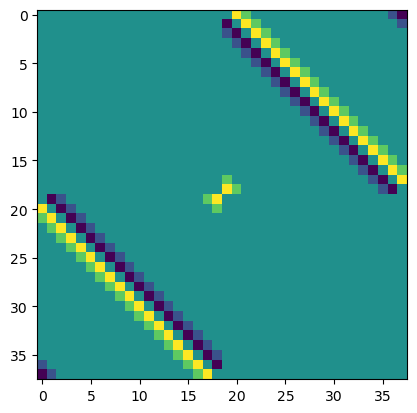

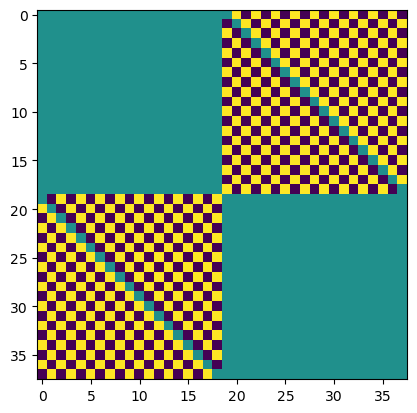

In [5]:
Hnl = inv(Phi.H)@H@inv(Phi)
plt.imshow(np.real(H.toarray()))
plt.show()
plt.imshow(np.real(Hnl.toarray()))
plt.show()

In [42]:
def cropped_nl_parameters(parameters, return_shape = False):
    Phi, H, P = local_operators(parameters)
    Hnl = inv(Phi.H)@H@inv(Phi)

    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = -np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    x1 = np.arange(1,Ny+1)
    x2 = np.arange(W,Ny+W)
    xx = np.concatenate((x1,x2))
    y1 = np.arange(0,Ny)
    yy = np.concatenate((y1,y1))
    
    edge_points = np.stack((xx,yy))
    normal_angles1 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles2 = -1*pi/4*np.ones(len(edge_points[0])//2)
    
    normal_angles = np.concatenate((normal_angles1,normal_angles2))
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2

    theta = parameters['theta']
    thetas = np.concatenate((theta*np.ones(int(len(boundary_spin_projections)/2)),(pi-theta)*np.ones(int(len(boundary_spin_projections)/2))))

    indices_to_delete = []
    

    for point in zip(edge_points[0], edge_points[1], thetas, boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], point[2], point[3]) 
        Hnl = rotation.H@Hnl@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return np.abs(x-(W+1)/2-y)/(W/2)
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x,y)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
        
    # Transforming the sparse matrix into dense to delete spins
    Hnl_aux = Hnl.toarray()
    Phi_aux = Phi.toarray()
   
    
    Hnl_aux = np.delete(Hnl_aux, indices_to_delete, axis=0)
    Hnl_aux = np.delete(Hnl_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    Hnl = csc_matrix(Hnl_aux)
    Phi = csc_matrix(Phi_aux)

    H = (Phi.H)@Hnl@Phi
    P = (Phi.H)@Phi
    
    
    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

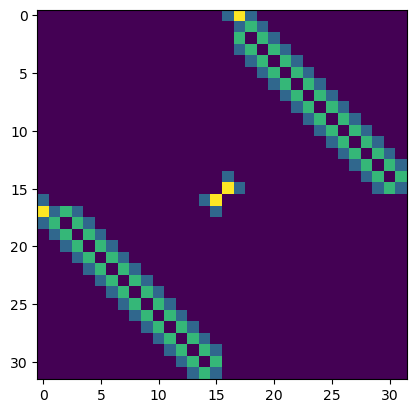

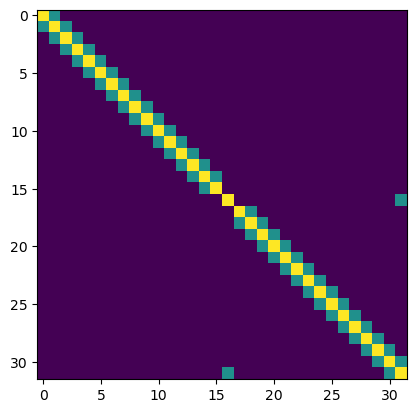

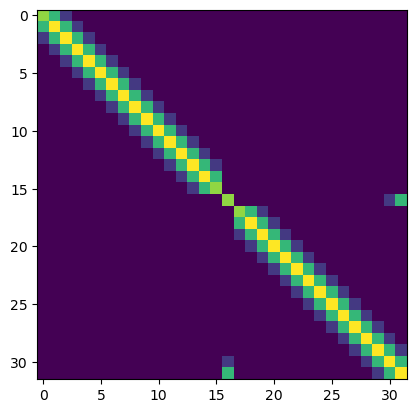

(-0.5, 18.5)

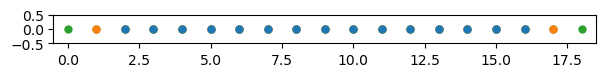

In [43]:
Ny = 1
i = 0 ### selected value of theta
W = 17
k = 0
Nx = Ny+W+1
parameters = dict(
    W = W,
    Ny = Ny,
    k = k,
    theta = (pi/2)*(i/100),
)


Phi, H, P, deleted_indices, spinup_shape, spindown_shape = cropped_nl_parameters(parameters, return_shape=True)
plt.imshow(np.abs(H.toarray()))
plt.show()

plt.imshow(np.abs(Phi.toarray()))
plt.show()

plt.imshow(np.abs(P.toarray()))
plt.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(np.arange(Nx),np.arange(Ny))
ax.scatter(spinup_shape[0],spinup_shape[1], s = 25)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 25,zorder=-1)
ax.scatter(X,Y,zorder=-2, s = 25)
ax.set_aspect('equal')
ax.set_ylim(-0.5,Ny-0.5)
ax.set_xlim(-0.5,W+Ny+0.5)

In [44]:
def make_bands_x(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem fro all k
    for j, k in enumerate(momenta):
        parameters['k'] = k
        Phi, H, P, deleted_indices = cropped_nl_parameters(parameters)
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-3, sigma = 1e-3, which = 'LM',return_eigenvectors = False)

    return momenta,bands


def plot_states(parameters,number_of_bands = 6):
    Phi, H, P, deleted_indices = cropped_nl_parameters(parameters)
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-10, sigma = 1e-10, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins

    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
            #states[index] = (eigenvectors)[index-count]
        else:
            count += 1

    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = -np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']
    
    for x in range(Nx):
        rotation = spin_rotation([x,2], theta, 0)
        states = (rotation.H)@states
        
    for x in range(Nx):
        rotation = spin_rotation([x,Ny-3], pi-theta, pi)
        states = (rotation.H)@states
        
    # The following five lines are necessary only if we expect to get two zero modes!!!!
    chirality = scipy.sparse.kron(csc_matrix(sigma_z), np.identity(Nx*Ny), format = "csc")
    save0 = (states[:,0]+chirality@states[:,0])/np.sqrt(2)
    save1 = (states[:,0]-chirality@states[:,0])/np.sqrt(2)
    states[:,0] = save0
    states[:,1] = save1

    norm = np.sqrt(np.diag(np.abs(states.conjugate().transpose()@states)))
    states = states/norm[None,:]   
    
    ###Now order and reshape
    order = np.argsort(np.abs(eigenvalues))
    states = np.reshape(states[:,order].flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')      
    energies = eigenvalues[order]
    
    #PLOT
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.flatten()

    for i in range(number_of_bands):
        probability_density  = np.sum(np.abs((states[i]))**2,axis = 0)
        spin_up_density  = np.abs((states[i,0]))**2
        spin_down_density  = np.abs((states[i,1]))**2    
        
        
        axs[i].plot(np.arange(Ny-4),  spin_up_density[2:-2], c = "C0")
        axs[i].scatter(np.arange(Ny-4),  spin_up_density[2:-2], c = "C0")
        axs[i].plot(np.arange(Ny-4),  spin_down_density[2:-2], c = "C1")
        axs[i].scatter(np.arange(Ny-4),  spin_down_density[2:-2], c = "C1")
        axs[i].set_ylabel(r"$E$ $(|\psi_\sigma|^2)$",fontsize = 18)
        axs[i].set_xlabel(r"$y$ $(a)$",fontsize = 18)
       
        formatted_number = f"{energies[i]:.4e}"
        axs[i].text(0.5, 0.5, "E= "+str(formatted_number), transform=axs[i].transAxes,
                fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

In [65]:
Ny = 1
i = 100 ### selected value of theta
W = 201
k = 0
Nx = Ny+W+1
nstates = 6
parameters = dict(
    W = W,
    Ny = Ny,
    k = k,
    theta = (pi/2)*(i/100),
)
nbands = 40
kmin = -pi/np.sqrt(2)
kmax = pi/np.sqrt(2)

momenta, bands = make_bands_x(parameters,number_of_bands = nbands, number_of_points = int(501),kmin = kmin, kmax = kmax)

-0.49760288907373673
0.5032488881825026
0.5046387650926087
-0.5032488881825012
-0.5046387650926062
0.5069822575646462
-0.506982257564644


(-0.4442882938158366, 0.4442882938158366)

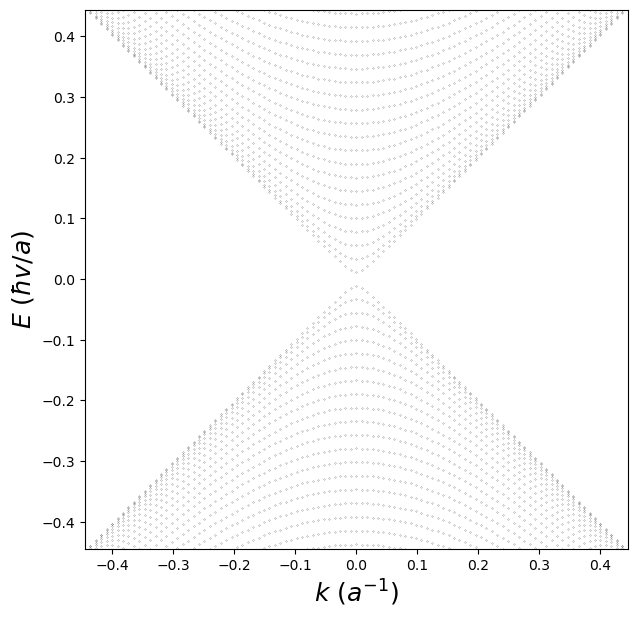

In [68]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
point = (np.abs(momenta + 0.5)).argmin()
print(momenta[point])

for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
for j in range(nstates):
    ax.scatter(momenta[point], bands[point,nbands-1-j], c = 'r', s = 10)
    print(bands[point,nbands-1-j])
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(kmin/5,kmax/5)
ax.set_xlim(kmin/5,kmax/5)

In [62]:
parameters['kx'] = momenta[point]

plot_states(parameters, number_of_bands=nstates)

IndexError: index 406 is out of bounds for axis 0 with size 406

In [ ]:
def operators_diag(parameters,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''

    W = parameters['W']
    Ny = parameters['Ny']
    k = parameters['k']       
    Nx = parameters['W'] + parameters['Ny']+ 1
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []

    for (x,y) in [(x,y) for y in range(Ny-1) for x in range(Nx)]:
        
        row_Tx += [x + Nx*y]
        col_Tx += [((x+1)%Nx) + Nx*y]
        data_Tx += [1]
        
        row_Ty += [x + Nx*y]
        col_Ty += [x + Nx*((y+1)%Ny)]
        data_Ty += [1]
        
    for x in range(Nx):
       
        row_Tx += [x + Nx*(Ny-1)]
        col_Tx += [((x+1)%Nx) + Nx*(Ny-1)]
        data_Tx += [1]
        
        row_Ty += [x + Nx*(Ny-1)]
        col_Ty += [(x - Ny) % Nx ] #Shift to the left! 
        data_Ty += [np.exp(-1j*k*Ny*np.sqrt(2))]

    
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    x1 = np.arange(1,Ny+1)
    x2 = np.arange(W,Ny+W)
    xx = np.concatenate((x1,x2))
    y1 = np.arange(0,Ny)
    yy = np.concatenate((y1,y1))
    
    edge_points = np.stack((xx,yy))
    normal_angles1 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles2 = -1*pi/4*np.ones(len(edge_points[0])//2)
    #normal_angles2 = 3*pi/4*np.ones(len(edge_points[0])//2)
    normal_angles = np.concatenate((normal_angles1,normal_angles2))
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
        
    theta = parameters['theta']
    indices_to_delete = []
    

    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return np.abs(x-(W+1)/2-y)/(W/2)
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x,y)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1
        
    # Transforming the sparse matrix into dense to delete spins is probably not the best way to do this
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [ ]:
Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_diag(parameters, return_shape = True)